# **Comparison between the qhat.py and wong.py modules**

This notebook contains a comparison between the modules `qhat.py` and `wong.py`. The `qhat.py` module computes the momentum accumulated by a jet moving along the $x$-axis. The `wong.py` module contains the Wong solver for dynamic partons moving through the Glasma. 

## Default simulation parameters for the Glasma and the Wong solvers

In [1]:
import numpy as np
import pickle
from tqdm import tqdm

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# General parameters
su_group = 'su3'        # Gauge group

# Simulation box parameters
L = 10      # Length of simulation box [fm]
N = 512     # Number of lattice sites
tau_sim = 1.0     # Simulation time [fm/c]
DTS = 8     # Time step

# MV model parameters
Qs = 2              # Saturation momentum [GeV]	
ns = 50     # Number of color sheets
factor = 0.8        # Ratio between Qs/g^2\mu for Ns = 50 color sheets
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))           # Running coupling constant		
mu = Qs / (g**2 * factor)           # MV model parameter	
ir = 0.1 * g**2 * mu         # Infrared regulator [GeV]
uv = 10.0           # Ultraviolet regulator [GeV]

# Jet related parameters
mass = 2.16/10**3      # Quark mass, up quark for example [GeV]
px = 1000    # Initial transverse momentum [GeV]
ntp = 100000   # Number of test particles

# Other numerical parameters
nevents = 1    # Number of Glasma events
folder = su_group + '_jets'       # Results folder

# Store relevant parameters in a dictionary
p = {
    'MASS': mass,           
    'PX': px,          
    'FOLDER': folder,         
    }

## Set environment variables

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
# Wong modules
from curraun import wong
wong.DEBUG = False
wong.REPRESENTATION = 'fundamental'
wong.BOUNDARY = 'periodic'
from curraun.wong import init_charge
# Kappa module
import curraun.qhat as qhat

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Path where results are saved
current_path = os.getcwd() 
results_folder = 'results'
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)
os.chdir(current_path + '/' + results_folder)

Using CUDA
Using SU(3)
Using double precision
Using double precision


## Simulation routine for evolving the Glasma & solving Wong's equations
Stores $\langle p_y^2\rangle$ and $\langle p_\eta^2\rangle$.

In [3]:
# Simulation routine
def simulate(p, ev): 
    output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)
    tau = np.linspace(0, tau_sim, maxt)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    px = p['PX'] / E0
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 4)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    mass = p['MASS'] / E0 
    m = mass * np.ones(ntp)

    for i in range(ntp):
        # Positions
        xT = np.random.rand(2) * s.n
        x0 = [xT[0], xT[1], 0.0]
        # Momenta, only along x-axis
        p0 = [0.0, px, 0, 0.0]
        # Charges
        q0 = init_charge()

        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, m)

    # xs = np.zeros((maxt-formt, ntp, 4))
    # ps = np.zeros((maxt-formt, ntp, 4))
    py, peta = np.zeros(maxt), np.zeros(maxt)

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            wong_solver.evolve()
            # xs[t] = wong_solver.x0.copy()
            # ps[t] = wong_solver.p.copy()
            pmu = wong_solver.p.copy()
            py[t], peta[t] = np.mean(pmu[:, 2]**2), np.mean(pmu[:, 3]**2)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    # Save results to a specific folder
    wong_folder = p['FOLDER']
    if not os.path.isdir(wong_folder):
        os.makedirs(wong_folder)
    wong_path = current_path + '/' + results_folder + '/' + wong_folder + '/'
    os.chdir(wong_path)

    # output['xs'], output['ps'] = xs, ps
    output['py'], output['peta'], output['tau'] = py, peta, tau
    filename = 'ev_' + str(ev+1) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)

    os.chdir(current_path + '/' + results_folder)

    return output

## Running the Wong solver over multiple Glasma events

In [4]:
pys, petas = [], []
for ev in range(nevents):
    output = simulate(p, ev)
    pys.append(output['py'])
    petas.append(output['peta'])

py_avg, peta_avg = np.mean(pys, axis=0), np.mean(petas, axis=0)

results = {}
results['py'], results['peta'], results['tau'] = py_avg, peta_avg, output['tau']
filename = 'wong_mom_broad_jets.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(results, handle)

Event 1: 100%|██████████| 409/409 [02:17<00:00,  2.97it/s]


## Simulation routine for jets

In [5]:
def simulate_qhat(p, ev): 
    output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    qhat_tforce = qhat.TransportedForce(s)
    py_qhat, pz_qhat = [], []
    tau_qhat = []

    if use_cuda:
        s.copy_to_device()
        qhat_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            if t % DTS == 0:
                if use_cuda:
                    qhat_tforce.copy_mean_to_host()

                py_qhat.append(qhat_tforce.p_perp_mean[1]) 
                pz_qhat.append(qhat_tforce.p_perp_mean[2])
                tau_qhat.append(t*a/DTS)
                
                if use_cuda:
                    qhat_tforce.copy_mean_to_device()

            qhat_tforce.compute()

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    qhat_folder = su_group + '_qhat'
    if not os.path.isdir(qhat_folder):
        os.makedirs(qhat_folder)
    qhat_path = current_path + '/' + results_folder + '/' + qhat_folder + '/'
    os.chdir(qhat_path)

    output['py'], output['pz'], output['tau'] = np.array(py_qhat), np.array(pz_qhat), np.array(tau_qhat)
    filename = 'ev_' + str(ev+1) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)

    os.chdir(current_path + '/' + results_folder)

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return output

## Run over multiple Glasma events and do averages

In [6]:
pys, pzs = [], []
for ev in range(nevents):
    output = simulate_qhat(p, ev)
    pys.append(output['py'])
    pzs.append(output['pz'])

py_avg, pz_avg = np.mean(pys, axis=0), np.mean(pzs, axis=0)

results = {}
results ['py'], results ['pz'], results ['tau'] = py_avg, pz_avg, output['tau']
filename = 'qhat_mom_broad_jets.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(results , handle)

Event 1: 100%|██████████| 409/409 [00:10<00:00, 38.12it/s]


## Read data from files using Julia

In [1]:
using Pickle

results = ["wong", "qhat"]

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

for r in results
    file = string_as_varname("file_" * r, "results/" * r * "_mom_broad_jets.pickle")
    data = string_as_varname("data_" * r, Pickle.npyload(file))
    string_as_varname(r,  data)
    string_as_varname("tau_" * r,  data["tau"])
end

## Plot the results using Makie from Julia

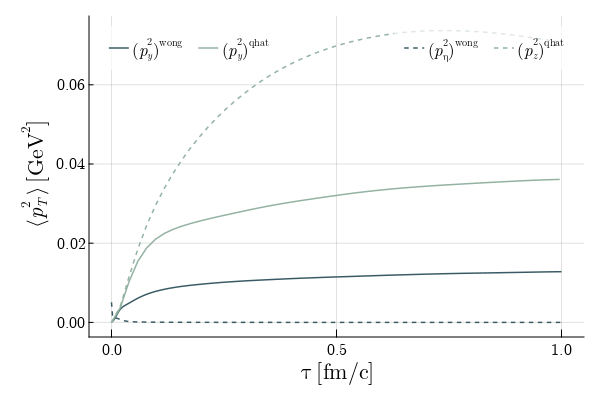

In [2]:
using CairoMakie
using ColorSchemes

starrynight = cgrad(:starrynight, 11, categorical = true)
colors = [starrynight[3], starrynight[6], starrynight[9]]
linestyles = [:dash, :dashdot, :dot]

fig = Figure(resolution = (600, 400), font = "CMU Serif")
axes = Axis(fig[1, 1], 
        xlabel=L"\tau\,\mathrm{[fm/c]}", ylabel=L"\langle p_T^2\,\rangle\,\mathrm{[GeV^2]}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 22, ylabelsize= 22, xticklabelsize=16, yticklabelsize=16,
        xtickalign = 1, xticksize=8, ytickalign=1, yticksize=5,  xlabelpadding = -5) 

wongy = lines!(axes, tau_wong, wong["py"], linewidth = 1.5, color=colors[1])
qhaty = lines!(axes, tau_qhat, qhat["py"], linewidth = 1.5, color=colors[2])

wongeta = lines!(axes, tau_wong, wong["peta"], linewidth = 1.5, color=colors[1], linestyle=linestyles[1])
qhatz = lines!(axes, tau_qhat, qhat["pz"], linewidth = 1.5, color=colors[2], linestyle=linestyles[1])

axislegend(axes, [wongy, qhaty], [L"(p_y^2)^\mathrm{wong}", L"(p_y^2)^\mathrm{qhat}"], labelsize=17, titlesize=19,
    position = :lt, orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

axislegend(axes, [wongeta, qhatz], [L"(p_\eta^2)^\mathrm{wong}", L"(p_z^2)^\mathrm{qhat}"], labelsize=17, titlesize=19,
    position = :rt, orientation = :horizontal, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

display(fig)
# save("mom_broad_qhat_wong.png", fig, px_per_unit = 5.0) 